In [2]:
from measurements.Pulse import Pulse
from measurements.PulseSequence import PulseSequence
from measurements.DataChannelManager import DataChannelManager

import measurements.Basics as basics

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from IPython.display import clear_output

In [3]:
from instruments.ATS9872_driver import * # alazar
from instruments.DG645_driver import * # delay generator
from instruments.M8195A_driver import * # awg
from instruments.E8257D_driver import * #RF source
from instruments.Agilent11713C_driver import * # attenuator
from instruments.SIM928_driver import * # Voltage source
from instruments.SIM970_driver import * # Voltage meter


In [1]:
instruments = {}

In [ ]:
instruments['awg'] = M8195A_driver('169.254.101.100')
instruments['alazar'] = ATS9872_driver()
instruments['att'] = Agilent11713C_driver('TCPIP0::169.254.101.101::inst0::INSTR')
instruments['RFsourceMeasurement'] = E8257D_driver('TCPIP0::169.254.101.103::inst0::INSTR')
instruments['RFsourceExcitation'] = E8257D_driver('TCPIP0::169.254.101.104::inst0::INSTR')
instruments['Voltsource'] =  SIM928_driver('GPIB0::2::INSTR',8,step_time=0.1,step_voltage=0.001)
instruments['Voltmeter'] = SIM970_driver('GPIB0::2::INSTR',5)

In [19]:
channelData = ms.prepareChannelData(awg, s1, 50e-6)

In [45]:
ms.updateChannelData(channelData,s1,'q1')

In [29]:
ms.loadChannelDataToAwg(awg,channelData,'m1')
awg.getError()

In [47]:
ms.loadChannelDataToAwg(awg,channelData,'q1')
awg.getError()

In [48]:
ms.setInstrumentsMarker(awg, channelData)
awg.getError()

In [75]:
parameters = {}

parameters['RFMeasurementLength'] = 5e-6 # in seconds
parameters['RFMeasurementAmplitude'] = 18 # in dBm, this a local oscillator, it feeds two mixers.

parameters['RFExcitationLength'] = 20e-6 # in seconds
parameters['RFExcitationAmplitude'] = 11 # in dBm, this a local oscillator, it feeds one mixers.
parameters['RFExcitationDelay'] = 0.1e-9 # delay before the next pulse
parameters['RFExcitationState'] = False # if the excitation should be on while the measurement happens

parameters['fluxValue'] =  -0.015 # in volts
parameters['fluxResistance'] = 8e3 # in ohms. this is for logging only. it is resistance used for the flux source
parameters['fluxState'] = True # if the flux should be on while the measurement happens

parameters['measurementLength'] = 125e-6 # in seconds. total duration of the measurement, pulses, delays, and relaxation time

# the total number of averages is numberOfBuffers times numberOfRecordsPerBuffers
parameters['numberOfBuffers'] = 100 # number of buffer used by alazar board in the acquisition.
parameters['numberOfRecordsPerBuffers'] = 50 # number of records per buffer used by alazar board in the acquisition.

parameters['waveformHeadCut'] = 500 # number of points to be cut from head of each record in alazar. 
parameters['amplitudeReferenceAlazar'] = 9 # in dBm. the amplitude of the reference signal arriving at the alazar.
parameters['decimationValue'] =  1 # should be 1, 2, 4 or multiples of 10. it divides the alazar board clock which is 1 GHz. The clock should be at least 4 times reference frequency.

parameters['MeasurementFrequency'] = 7400e6 # in Hz, the frequency of the measurement pulse
parameters['ExcitationFrequency'] = 5012e6 # in Hz, the frequency of the excitation pulses
parameters['Measurement_IF'] = 70e6 # in Hz, the frequency of the measurement pulse
parameters['Excitation_IF'] = 240e6 # in Hz, the frequency of the measurement pulse

parameters['attenuation'] = 30 # in dB, attenuation
parameters['backgroundPlotValue'] = -60 # in dB




# Cavity

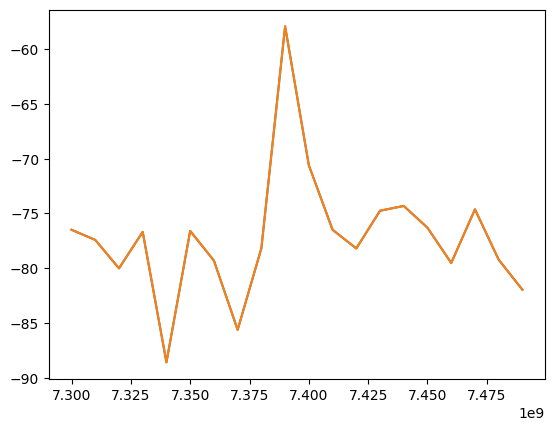

In [88]:
initial_freq = 7300e6
final_freq = 7500e6
step_Freq = 10e6

freqs = np.arange(initial_freq,final_freq,step_Freq)


basics.cavity_measure(instruments,parameters,freqs)

# Twotone

In [ ]:
initial_freq = 5000e6
final_freq = 5020e6
step_Freq = 1e6

parameters['MeasurementFrequency'] = 7400e6

qfreqs = np.arange(initial_freq,final_freq,step_Freq)

basics.twotone_measure(instruments,parameters,qfreqs)